# **2. Dropout model**

Our next goal is optimizing the base model so that we can reach higher accuracies and avoid overfitting as much as possible. We will first start by increasing the complexity of the base model (i.e., adding more layers), as well as incorporating regularization techniques to prevent us from overfitting to the training set. 

In this notebook we will explore the power of dropout for helping us reduce overfitting to the data. We will start by building a similar architecture to the one used by the base model, reusing the weights from the previously trained model. 

We will start by defining a dropout rate of 0.5 after the last fully connected layer. Since we will be increasing the number of samples by using data augmentation later on, using a higher penalty will probably hinder the training process and ultimately causing the model to meet early stopping criteria before converging.

# Introduction

## Dropout

Dropout is a regularization technique used to prevent overfitting during the training process, where some of the neurons of neurons in the CNN are randomly selected and their outputs are ignored during training. The percentage of neurons dropped depends on a certain probability, which we can indicate when building the model. This random dropout of neurons will force the model to find more robust by learning multiple independent features, as it cannot always rely on the presence of all neurons to extract features from the image.

When applying the CNN to an inference problem, all neurons are used, but their outputs are scaled down by the same factor as the dropout probability used during training to ensure that the expected value of each neuron is the consistent with the training process.

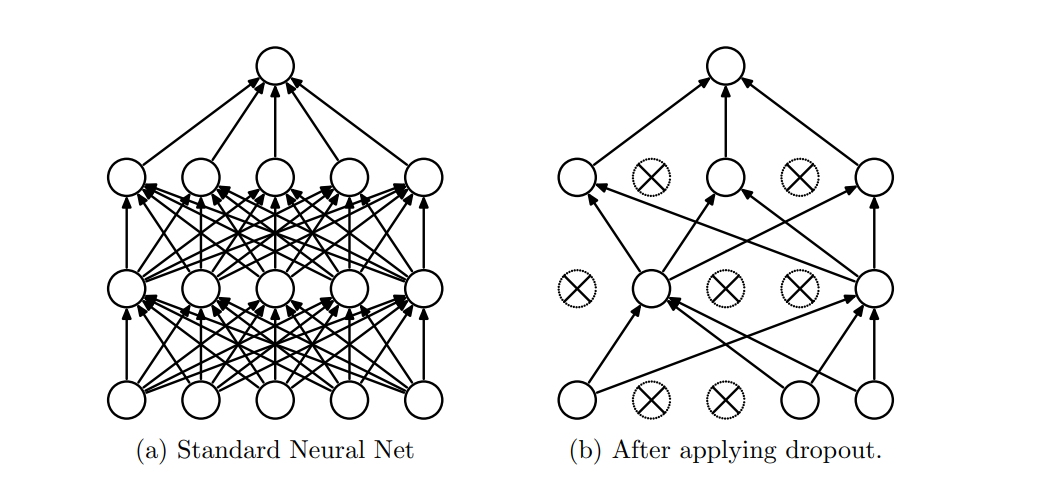

**Sources**:

+ Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/v15/srivastava14a.html). Journal of Machine Learning Research, 15(56), 1929-1958.
+ Hinton, G.E. et al. (no date) Improving neural networks by preventing co-adaptation of feature detectors, NASA/ADS. Available at: https://ui.adsabs.harvard.edu/abs/2012arXiv1207.0580H/abstract (Accessed: April 1, 2023). 
+ Brownlee, J. (2019) A gentle introduction to dropout for Regularizing Deep Neural Networks, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ (Accessed: April 1, 2023). 

First of all, let's load the required libraries in order to run the code:

In [1]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves

Now let's see how our data is structured:

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Baroque', 'Realism', 'Renaissance', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Baroque       4000         500   500
Realism       4000         500   500
Renaissance   4000         500   500
Romanticism   4000         500   500


# 2.1. Model structure

Let's first create the model structure:

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (256, 256,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [8]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=input_shape
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
         )
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax'))

In this case, we have included a single dropout layer in the classifier part of the network, which is the one that typically converges faster and thus needs more regularization efforts.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

With respect to the optimizer, we will use the same one as before, Adam, with a learning rate of 0.0001.

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

# 2.2. Data preprocessing

The preprocessing steps are the same as before:

In [11]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128, 4)


# 2.3. Training

We can now train this modified version of our base model and see if it improves performance upon the first version. We will still implement `EarlyStopping` to make sure we avoid *overfitting* as much as possible, as well as `ModelCheckpoint` to save the best model weights.

In [13]:
# Model name and path
model_path = os.path.join("models", "dropout_model.h5")

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
  1/125 [..............................] - ETA: 14:53 - loss: 1.3876 - acc: 0.2422

c:\Users\carlo\anaconda3\envs\venv_art\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.2702 - acc: 0.4207
Epoch 1: val_loss improved from inf to 1.12679, saving model to models\dropout_model.h5
125/125 [==============================] - 644s 5s/step - loss: 1.2702 - acc: 0.4207 - val_loss: 1.1268 - val_acc: 0.5578
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.1268 - acc: 0.5178
Epoch 2: val_loss improved from 1.12679 to 1.12130, saving model to models\dropout_model.h5
125/125 [==============================] - 549s 4s/step - loss: 1.1268 - acc: 0.5178 - val_loss: 1.1213 - val_acc: 0.5375
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.0612 - acc: 0.5519
Epoch 3: val_loss improved from 1.12130 to 1.05073, saving model to models\dropout_model.h5
125/125 [==============================] - 540s 4s/step - loss: 1.0612 - acc: 0.5519 - val_loss: 1.0507 - val_acc: 0.5820
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 1.0289 - acc: 0.5646
Epoch 4: 

Now let's save the best model found before stopping:

In [16]:
# load the saved model
dropout_model = load_model(model_path)

### 2.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

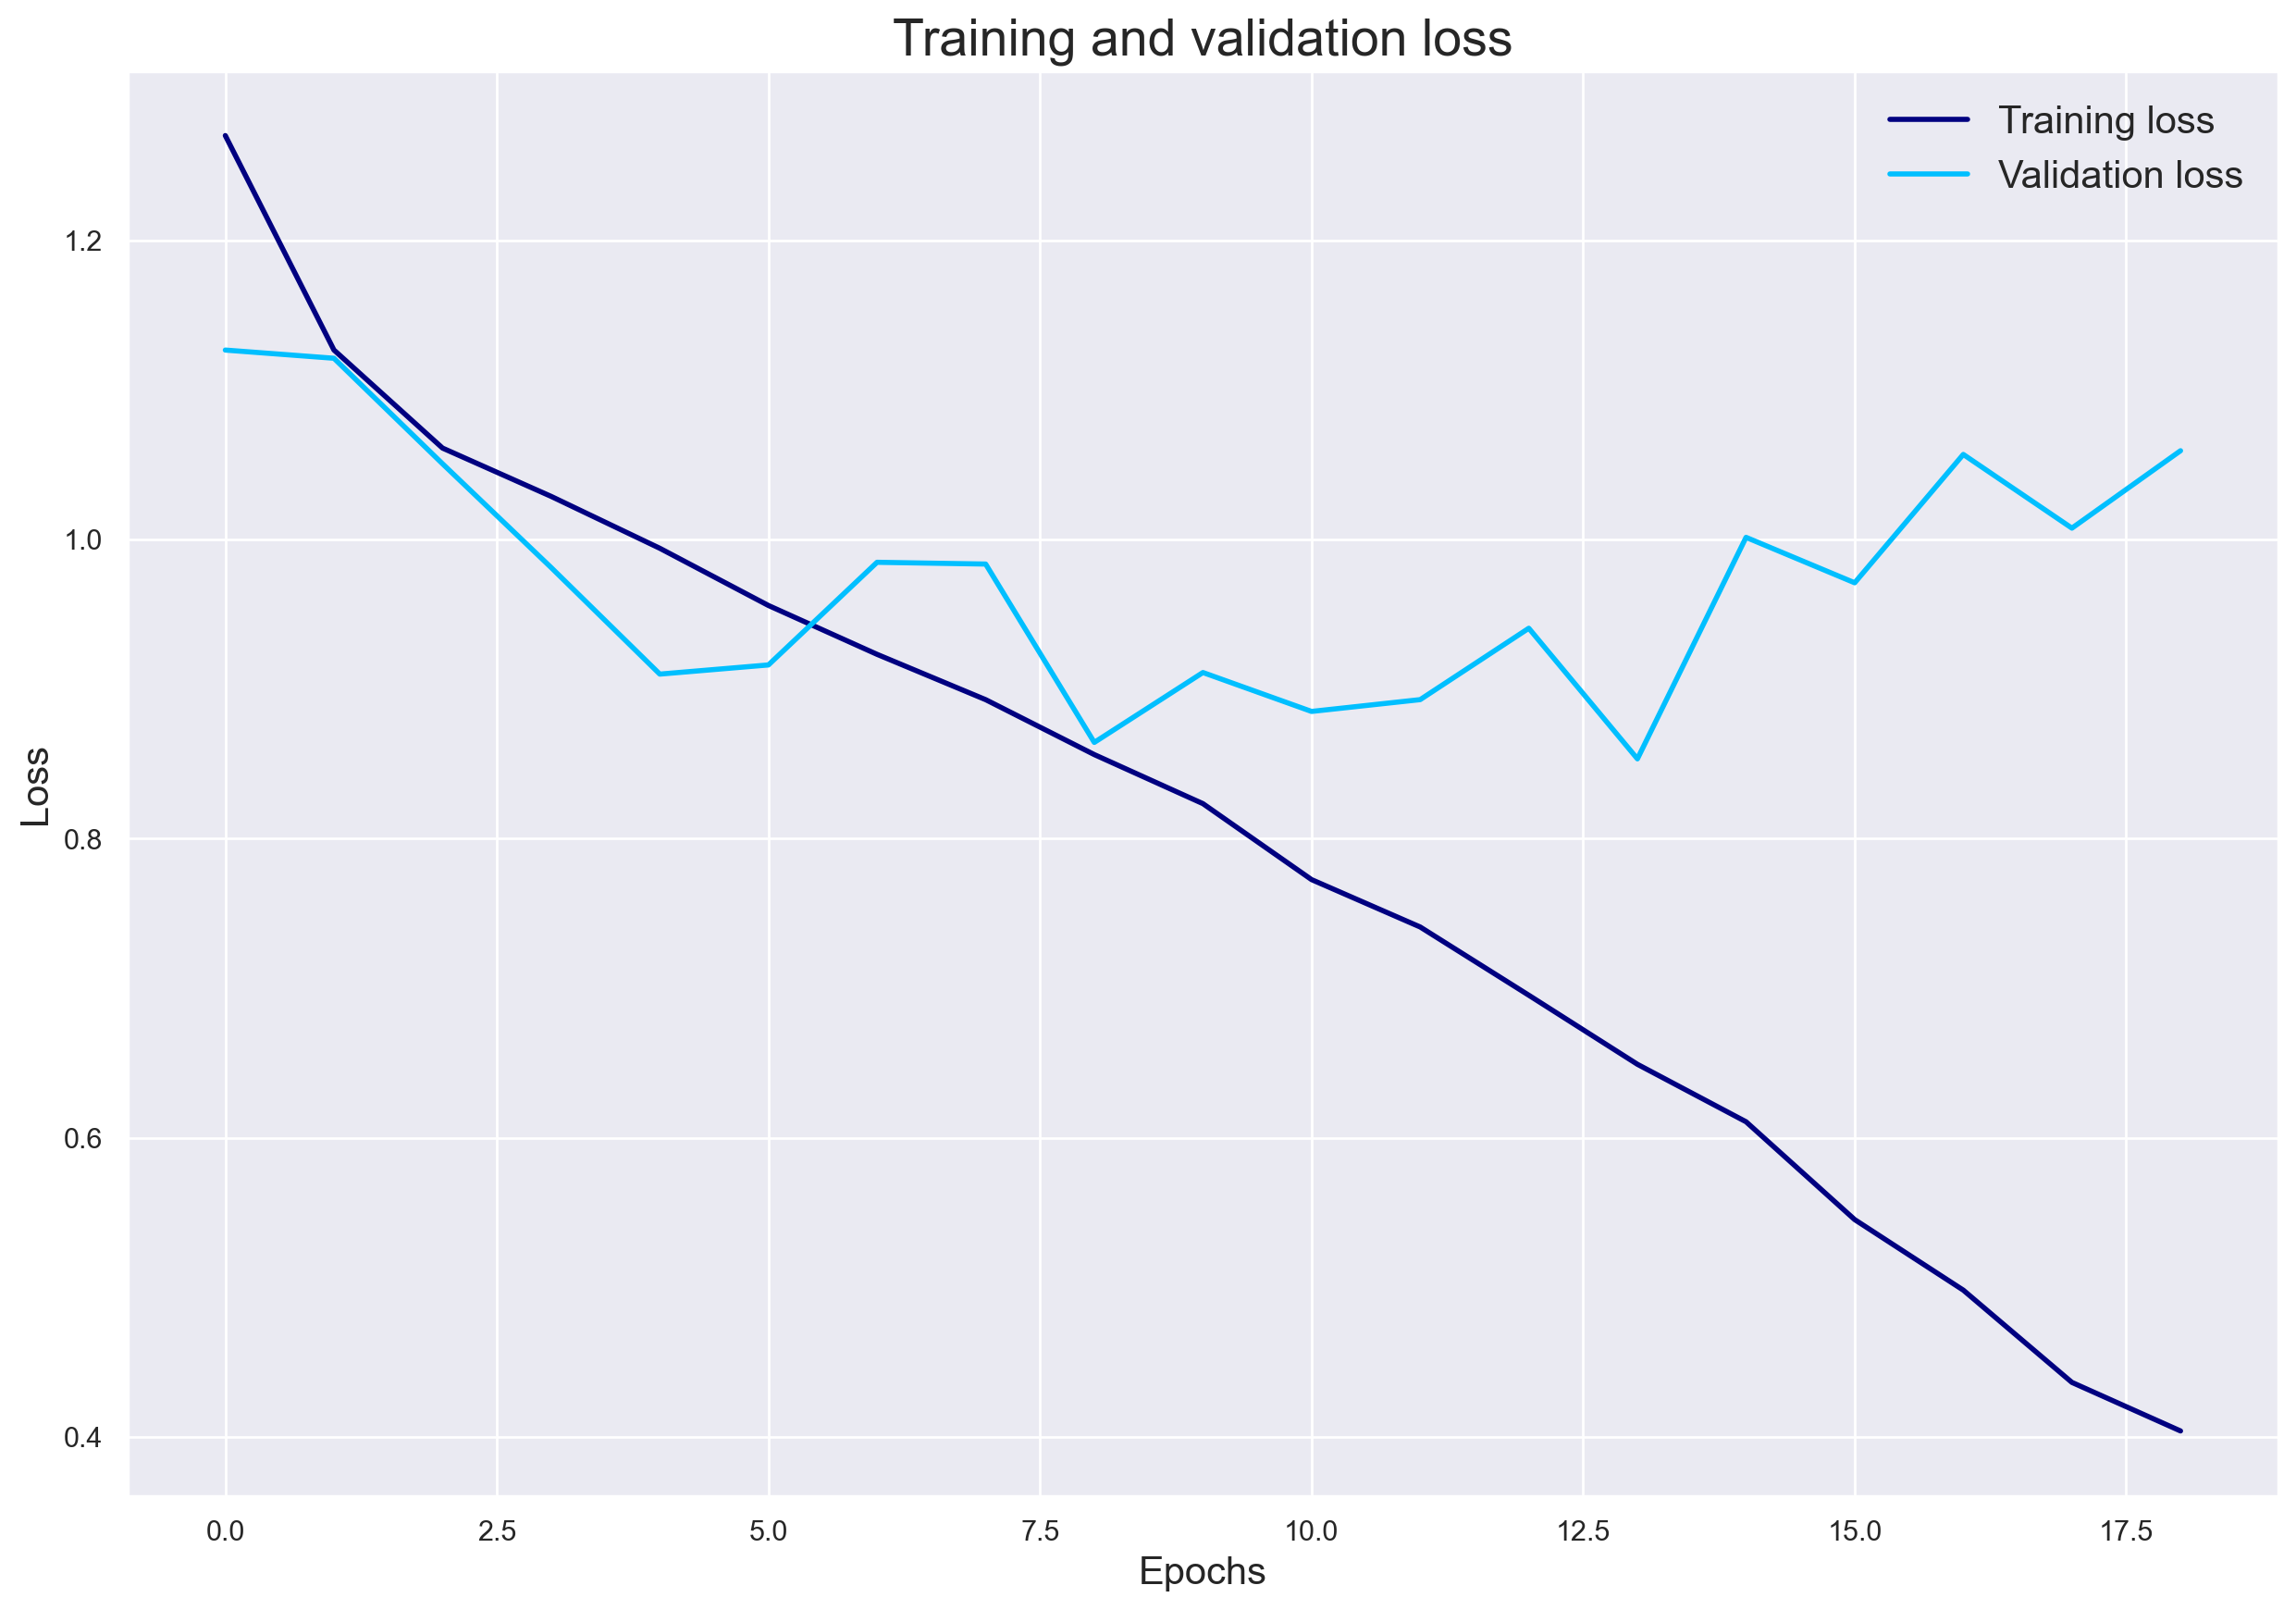

In [18]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss")

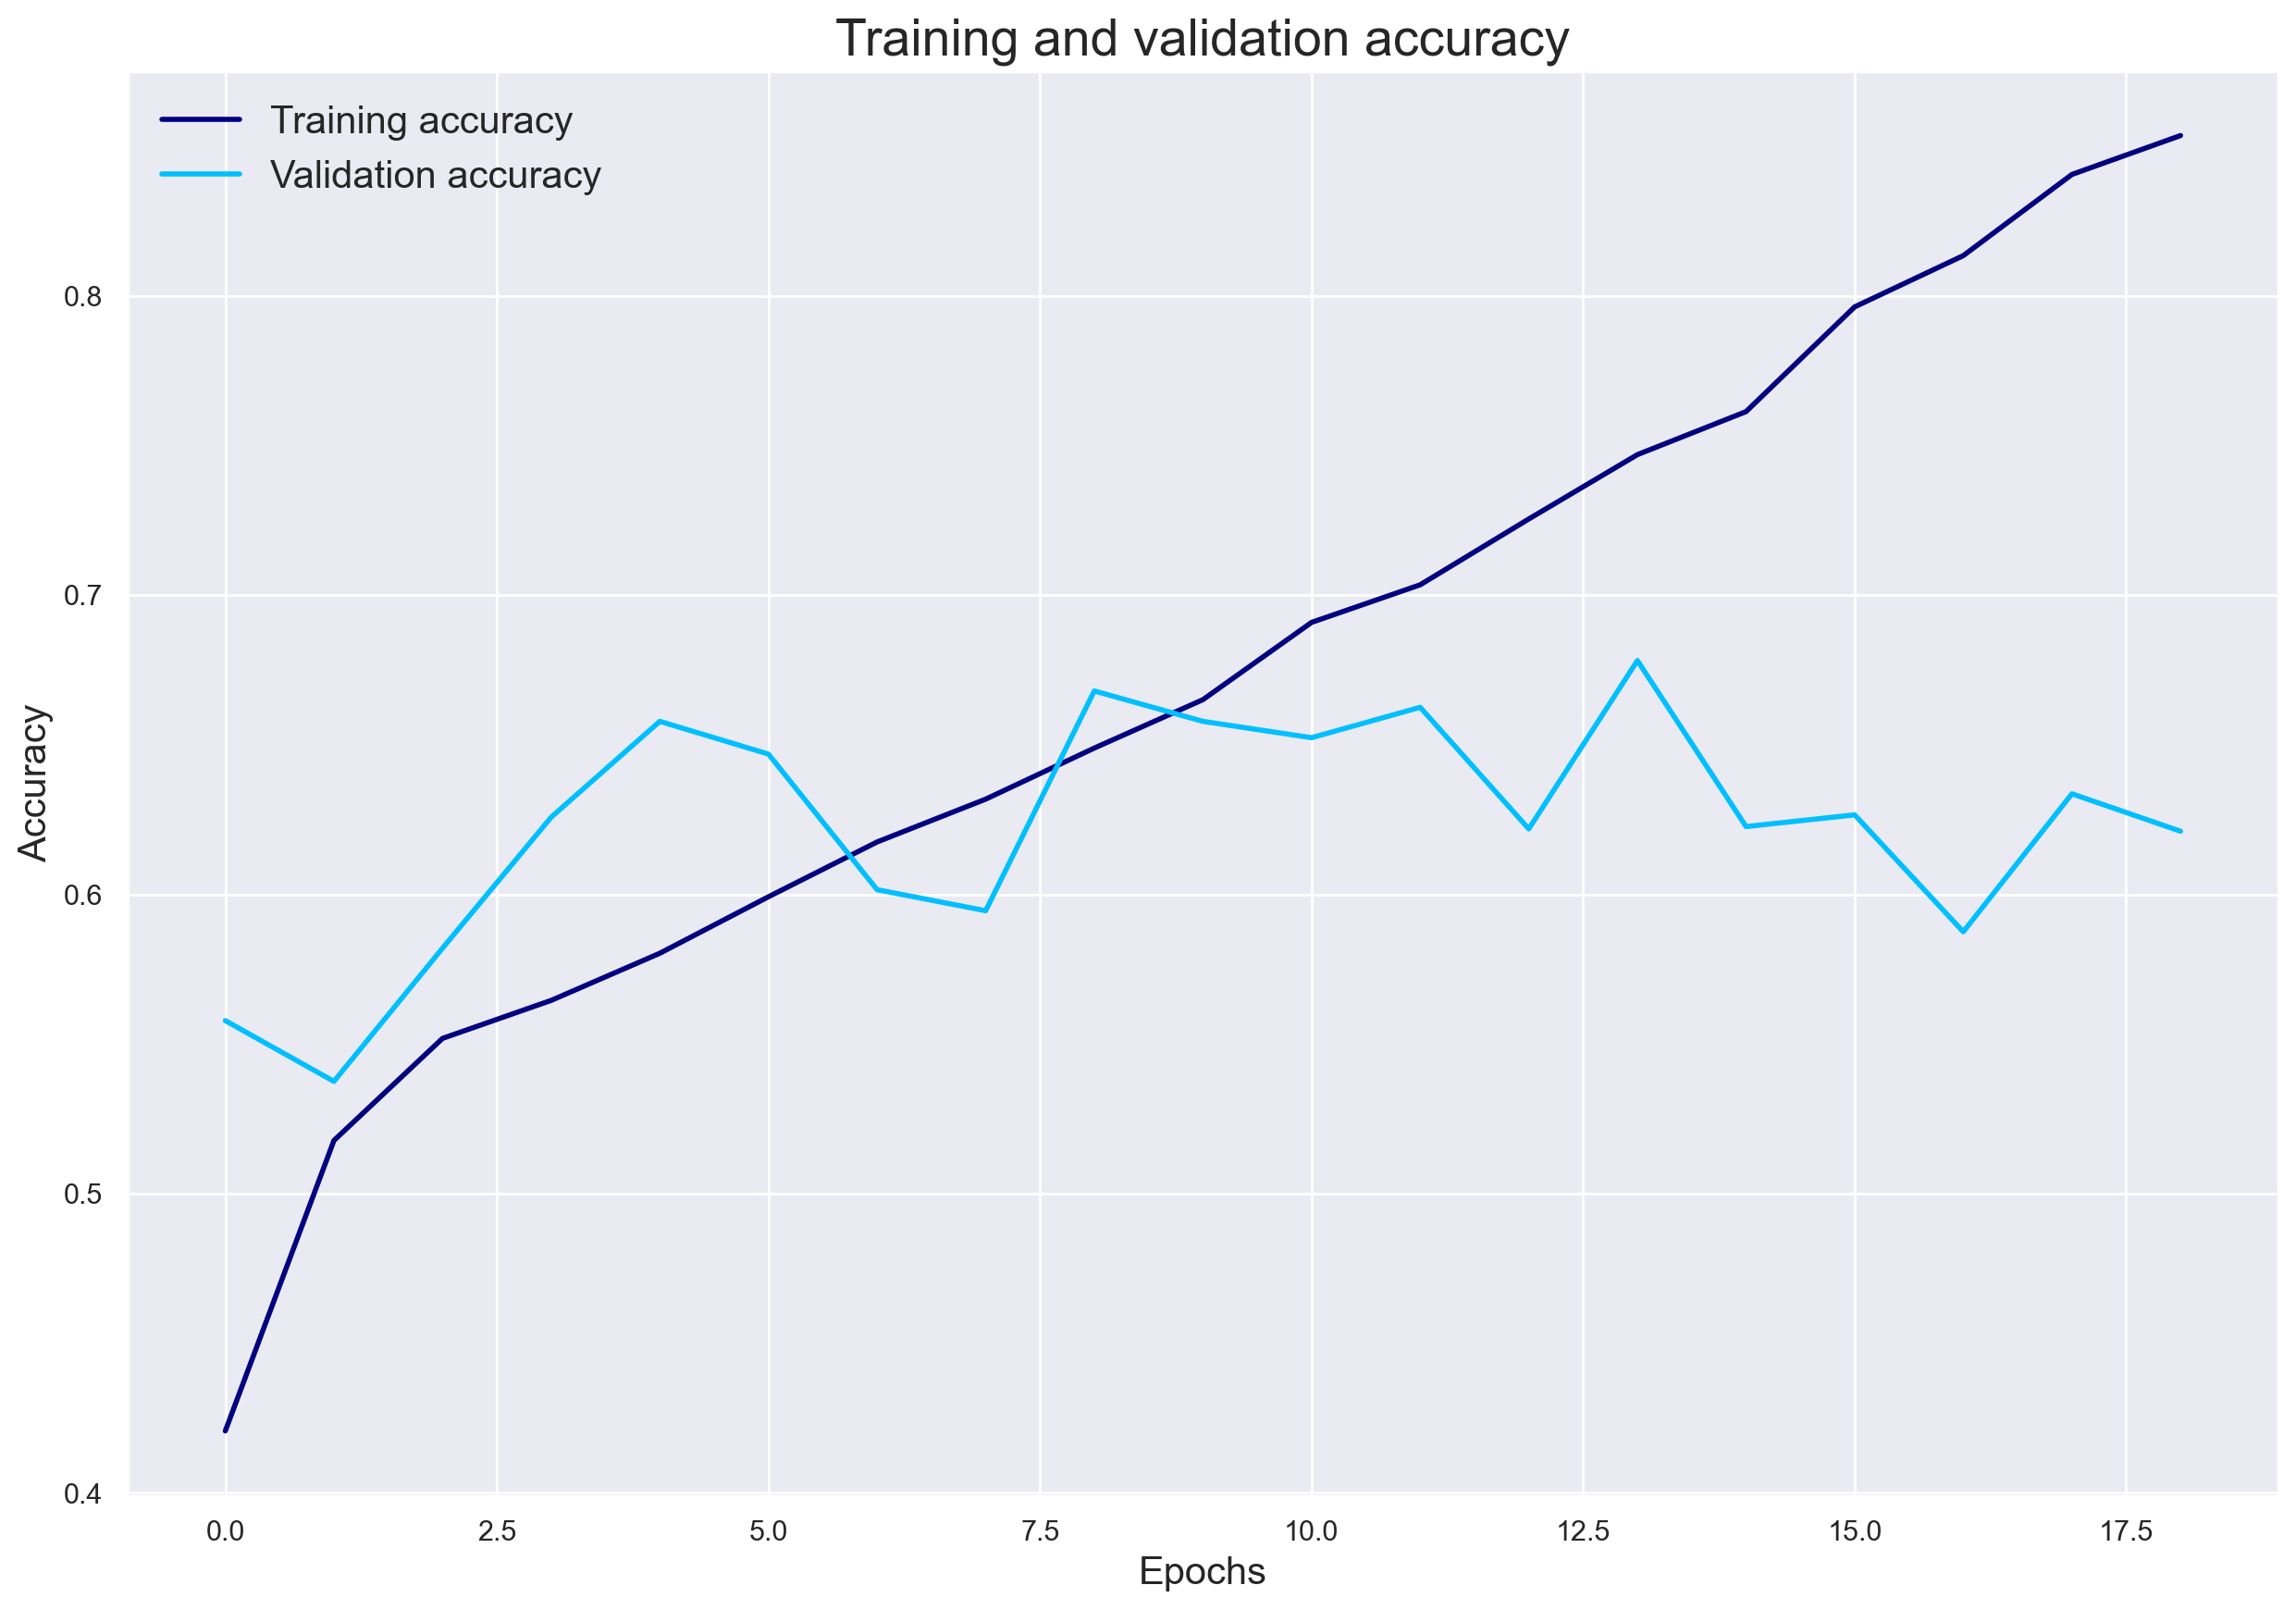

In [19]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy")

Looking at the above graphs we can see that Dropout indeed improved the training process. Compared to our base model, the evolution of the loss function in the validation dataset is much smoother, although peaks and valleys are still present. 

In this case, the validation accuracy is similar to the one obtained for the base model (over 80%) but we did not manage to significantly reduced overfitting, as the validation accuracy is similar to the one obtained in the base model.

In [21]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
        )

Found 2000 images belonging to 4 classes.


In [23]:
dropout_model.evaluate(test_generator)

50/50 [==============================] - 49s 979ms/step - loss: 0.9610 - acc: 0.6220


[0.9609625339508057, 0.621999979019165]

Unfortunately, the level of dropout implemented was not enough to significantly improve the results in our separated test dataset, achieving similar results compared to the base model.